# Inverse Noise Weighting

Say you have **M measurements** with some noise and **N parameters** that you need to fit for.

$$ g_i g_j^* V_{ij}^M = V_{ij} + n_{ij} = V_{ij}' $$
$$ g_l g_m^* V_{ij}^M = V_{lm} + n_{lm} = V_{lm}' \dots{}$$

The system of equations can be represented by the matrix equation:
$$ [A]_{M\times N}[X]_{N\times 1} = [Y]_{M\times 1} $$

where A is the matrix of coefficients, X is the matrix of parameters ($g_i$, $g_j$, ... $V_{ij}$... ) and Y is matrix of measurement results which are noisy (with unknown noise properties in general).

The solution of the system of linear equations is given by:
$$ X = (A^{\dagger}N^{-1}A)^{-1}A^{\dagger}N^{-1}Y$$


$$N = nn^{\dagger}$$

## Noise matrix

The noise matrix is defined as:
$$N = \langle nn^{\dagger} \rangle$$

The angular brackets denote a statistical ensemble average but since each measurement is theoretically assumed to be independent, this can be estimated from a time average also. In the strictest terms, the probability distribution function of the noise in the data should be determined and the noise matrix is the this is the mean of that distribution. More practically, it is the expectation value of the noise for different measurements.

Some properties of the noise matrix:

1. Is a diagonal matrix if there is no covariance.
2. Is proportional to the identity matrix if all measurements have the same noise. $N = nI$
3. If the noise is drawn from a normal distribution, the chi squared is given by the exponent of a guassian.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

### Fit for a straight line

The eigen vectors of a matrix representing data points on a straight line, are a vector pointing in the direction of the line and a vector perpendicular to it. The eigen value of the vector along the line is best constrainted and the eigen value perpendicular is little constrained to not constrained at all depending on the uncertainity in the data.

<IPython.core.display.Javascript object>


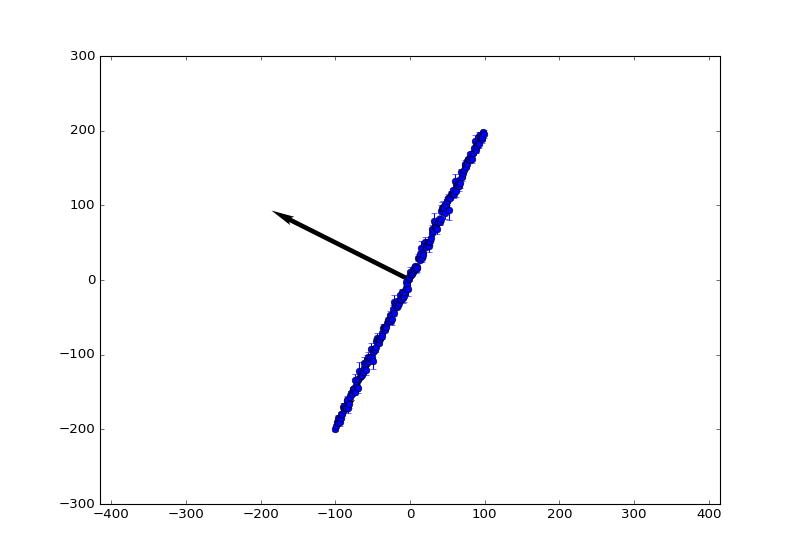

In [11]:
# Generate data
datapoints = 200

x = np.linspace(-100,99,num=datapoints)
n = np.random.normal(scale=5,size=datapoints)
y = 2*x + 3 + n

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(x,y,yerr=n,fmt='o')
plt.show()

In [12]:
# Generating N as some noise times the identity matrix
# -- all the noise is drawn from the same distribution.
# Scaling factor is the variance of the distribution 
# the noise was drawn from.
N = 25*np.identity(datapoints)
Ninv = np.linalg.inv(N)

In [13]:
A = np.transpose(np.matrix([x,y]))
Y = np.transpose(np.matrix(np.ones(datapoints)))
print Ninv.shape, A.shape, Y.shape

(200, 200) (200, 2) (200, 1)


In [14]:
# Since A is real, dagger is just transpose.

x1 = np.linalg.inv(np.dot(A.T,np.dot(Ninv,A)))
x2 = np.dot(A.T,np.dot(Ninv,Y))
X = np.dot(x1,x2)
print X

[[-0.20818864]
 [ 0.10449228]]


In [15]:
# Define matrix M as params averaged over all measurements
M = np.dot(A.T,A)
print M

[[  666700.          1327364.71919976]
 [ 1327364.71919976  2648535.4242042 ]]


In [16]:
np.linalg.inv(M)

matrix([[ 0.00068235, -0.00034197],
        [-0.00034197,  0.00017176]])

In [17]:
U,s,V = np.linalg.svd(M)

In [18]:
print U, s, V

[[-0.44820812 -0.89392924]
 [-0.89392924  0.44820812]] [  3.31406421e+06   1.17121133e+03] [[-0.44820812 -0.89392924]
 [-0.89392924  0.44820812]]


In [24]:
idxs = np.array([[0,0,U.item((0,0)),U.item((1,0))],[0,0,U.item((0,1)),U.item((1,1))]])
Xq,Yq,Uq,Vq = zip(*idxs)

plt.axis('equal')
plt.quiver(Xq,Yq,Uq,Vq,headwidth=2,scale=1,units='xy')
plt.grid()

# Eigen Spectrum

The Eigen spectrum shows how well constrained the parameters are. Higher the eigen value, lower the noise on that parameter. Degenerate parameters have an eigen value of zero, implying that they cannot be constained at all.

<IPython.core.display.Javascript object>


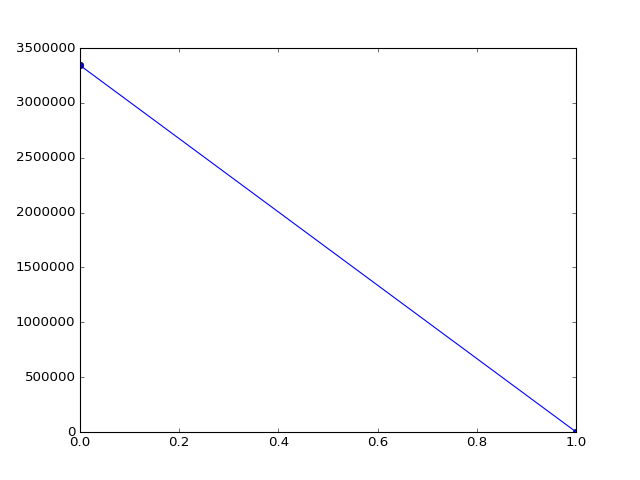

In [11]:
plt.plot(np.arange(2),s,'o-')
plt.show()

In [12]:
np.round(U,decimals=2)

array([[-0.45, -0.89],
       [-0.89,  0.45]])

In [13]:
np.round(M,decimals=2)

array([[  666700.  ,  1334246.69],
       [ 1334246.69,  2676708.5 ]])

In [14]:
s

array([  3.34210772e+06,   1.30077257e+03])

### Generate matrix A for the HERA antenna layout

In [25]:
import hera_cal

Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

In [26]:
def genA(redbls):
    # number of measurements = total number of baselines
    M = 0
    for i in range(len(redbls)):
        M += len(redbls[i])
    
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = 1+1j
            A[i,pair[1]] = 1-1j
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [27]:
A = genA(redbls)

In [28]:
print A.shape, Nants+len(redbls)

(666, 100) 100


In [29]:
np.real(A)

matrix([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [30]:
np.real(A[0])

matrix([[ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [64]:
M = np.dot(np.real(A).T,np.real(A))
print M.shape, M[0]

(100, 100) [[ 36.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.   1.
    1.   1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   1.   1.   0.
    1.   1.   1.   0.   1.   1.   1.   0.   0.   1.   0.   0.   1.   1.
    1.   1.   0.   0.   0.   0.   1.   0.   1.   0.   1.   0.   1.   1.
    0.   1.   0.   0.   0.   0.   1.   1.   0.   1.   0.   0.   0.   1.
    0.   0.]]


In [65]:
U,S,V = np.linalg.svd(M)

<IPython.core.display.Javascript object>


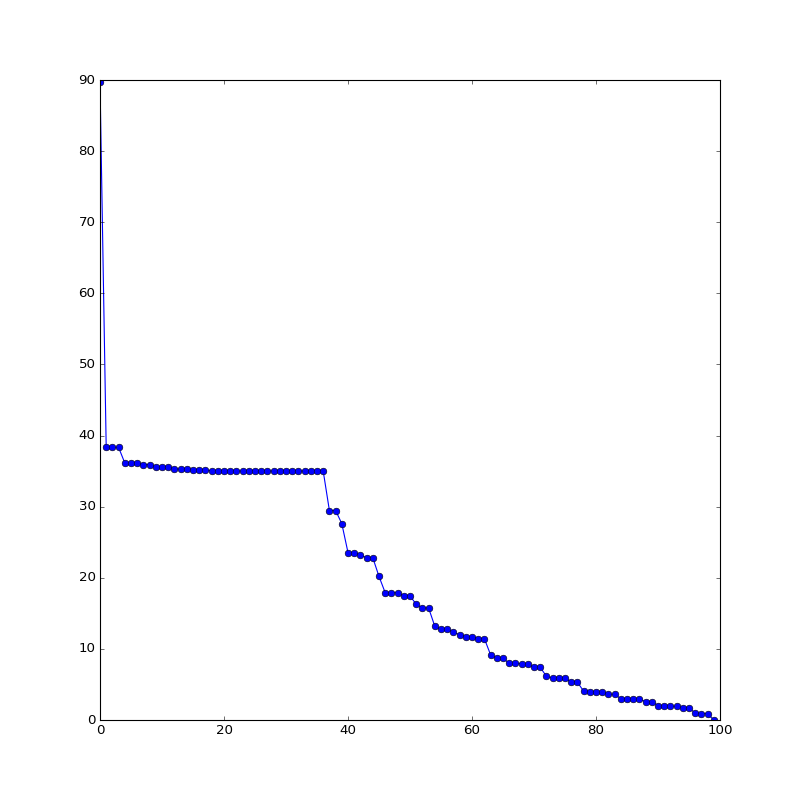

In [96]:
plt.figure(figsize=(10,10))
plt.plot(S,'o-')
plt.show()

In [77]:
U = U.A1.reshape(M.shape)

<IPython.core.display.Javascript object>


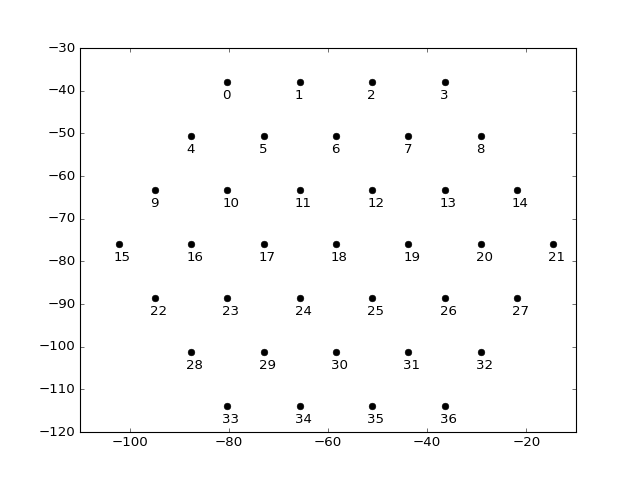

In [68]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]-1,v[1]-4))
plot_ants(antpos)

In [83]:
x = np.arange(M.shape[0])
xlabels = np.array(['g%d'%n for n in range(Nants)])
xlabels = np.append(xlabels, ['V_%d-%d'%redbls[i][0] for i in range(100-37)])
print len(xlabels), len(U[0])

100 100


<IPython.core.display.Javascript object>


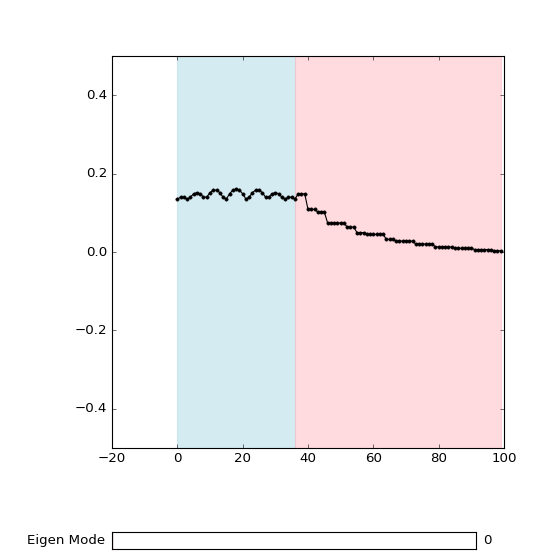

0

In [131]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.subplots_adjust(left=0.2,bottom=0.2)

l, = plt.plot(x, U[:,0],'.-',color='black')
ax.set_ylim([-0.5,0.5])
ax.axvspan(0,36,alpha=0.5,color='lightblue')
ax.axvspan(36,99,alpha=0.5,color='lightpink')
axmode = plt.axes([0.2, 0.02, 0.65, 0.03])

smode = Slider(axmode, 'Eigen Mode', 0, 100, valinit=0, valfmt=u'%d')

def update(val):
    v = int(val)
    l.set_ydata(U[:,val])
    fig.canvas.draw_idle()
    
smode.on_changed(update)

In [44]:
U[:,-1]

matrix([[ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0

In [45]:
U[:,0]

matrix([[ 0.13499132],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.14869663],
        [ 0.1516153 ],
        [ 0.14869663],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.1516153 ],
        [ 0.15794249],
        [ 0.15794249],
        [ 0.1516153 ],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.14869663],
        [ 0.15794249],
        [ 0.16117712],
        [ 0.15794249],
        [ 0.14869663],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.1516153 ],
        [ 0.15794249],
        [ 0.15794249],
        [ 0.1516153 ],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.14869663],
        [ 0.1516153 ],
        [ 0.14869663],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.1484167 ],
        [ 0.1484167 ],
        [ 0.1484167 ],
        [ 0.10860538],
        [ 0.10860538],
        [ 0.10860538],
        [ 0

In [57]:
U[:,1]

matrix([[ 0.21397922],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.12865952],
        [ 0.00426969],
        [-0.07052632],
        [ 0.00426969],
        [ 0.12865952],
        [ 0.12865952],
        [-0.07052632],
        [-0.2192312 ],
        [-0.2192312 ],
        [-0.07052632],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.00426969],
        [-0.2192312 ],
        [-0.30571807],
        [-0.2192312 ],
        [ 0.00426969],
        [ 0.21397922],
        [ 0.12865952],
        [-0.07052632],
        [-0.2192312 ],
        [-0.2192312 ],
        [-0.07052632],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.00426969],
        [-0.07052632],
        [ 0.00426969],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.21397922],
        [-0.08316703],
        [-0.08316703],
        [-0.08316703],
        [-0.10543244],
        [-0.10543244],
        [-0.10543244],
        [-0